# Modelling parking spots availability

## Summary
This code is a toy example of modelling *parking spots availability* (real-world data), with the machine-learning library *scikit-learn*.
 
 The data consists of series in/out parking events with exact time (5 working days) and location (a street neighborhood).
 The assumption made is that the dataset set covers ~ 40% of all data (sampled by a mobile parking app). The goal is to build a model that estimates availability at any given time.
 
 The first analysis reveals that data is clustered by location, and that the availability over time exhibits both *trendiness* ('Friday effect') and *seazonality* ('rush hours'). As the second step, gaussian stochastic processes are used to fit a regression model which estimates availability addressing sampling errors.
The trend-seazonality decomposition requires non-trivial *kernel engineering*; this is illustrated by mixing three different types of kernels, which correctly captures the observed trendiness and seazonality. 

The model trained with only 50 samples fits quite well the data and behaves as expected, in a qualitative sense, for 2 next days. This shows that the approach is sound and doesn't overfit, but more modelling and much more data are needed to get accurate quantitave bounds.

## Libraries

In [1]:
import pandas as pnd
import numpy as np

import os

import sklearn
from sklearn import cluster 
from sklearn.neighbors import kneighbors_graph

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels

from matplotlib import pyplot as plt
from matplotlib import dates as mdates

## Data extraction

In [2]:
# the path to the datafile

train_data_path = 'data.json'

# note: this is not a correct json file, but a collection of json objects, line-by-line; needs to be parsed!
with open(train_data_path,'r') as f:
    lines = f.readlines()
    
s_json = '['+','.join(lines)+']'

data = pnd.read_json(s_json)

# inspect the raw data

data[0:10]

,lat,lon,ts,type
0,48.23048,16.36510,2017-02-06 00:15:43,IN
1,48.23088,16.36457,2017-02-06 00:29:20,IN
2,48.22783,16.36765,2017-02-06 00:30:31,IN
3,48.23078,16.36477,2017-02-06 00:33:23,OUT
4,48.23111,16.36465,2017-02-06 01:02:29,IN
5,48.23099,16.36436,2017-02-06 01:04:23,OUT
6,48.23027,16.36495,2017-02-06 01:04:58,IN
7,48.23033,16.36521,2017-02-06 01:26:56,IN
8,48.22948,16.36596,2017-02-06 01:32:36,IN
9,48.22784,16.36793,2017-02-06 01:37:12,IN


In [3]:
print('Data consists of %s rows'%data.shape[0])

Data consists of 5954 rows


## Data analysis

### Summary Description

In [4]:
print('Time range: from %s to %s '%(min(data['ts']),max(data['ts'])))
# we have only 5 days of data

Time range: from 2017-02-06 00:15:43 to 2017-02-10 23:59:30 


In [5]:
print('Location: %s+-%s, %s+-%s'%(data['lat'].mean(),2*data['lat'].std(),data['lon'].mean(),data['lon'].std()))

# looks like the location is highly concentrated

Location: 48.2304176654+-0.00482623122228, 16.364833386+-0.00232668337442


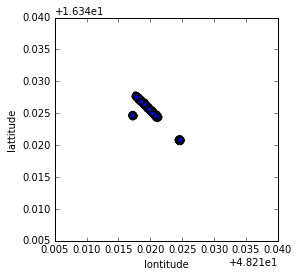

In [6]:
# illustrate locations

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1,1,1)  
ax.scatter(data['lat'],data['lon'])

plt.ylabel("lattitude")
plt.xlabel("lontitude")

plt.show()

Parking locations seem to be concentrated around three places.

### Clustering location

In [7]:
# compute clusters

# extract location information
X = data[['lat','lon'] ]

# note! we impose extra local constraints: neighbours should go to the same cluster

connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
connectivity = connectivity+connectivity.T # makes the matrix symmetric

# cluster data - note: different linkage criteria may lead to worse clustering
clstr = cluster.AgglomerativeClustering(linkage="average",n_clusters=3, connectivity=connectivity)                                        
clstr.fit(X)

/home/mskorski/.local/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:418: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<5954x5954 sparse matrix of type '<class 'numpy.float64'>'
	with 70492 stored elements in Compressed Sparse Row format>,
            linkage='average', memory=Memory(cachedir=None), n_clusters=3,
            pooling_func=<function mean at 0x7f48a9f25c80>)

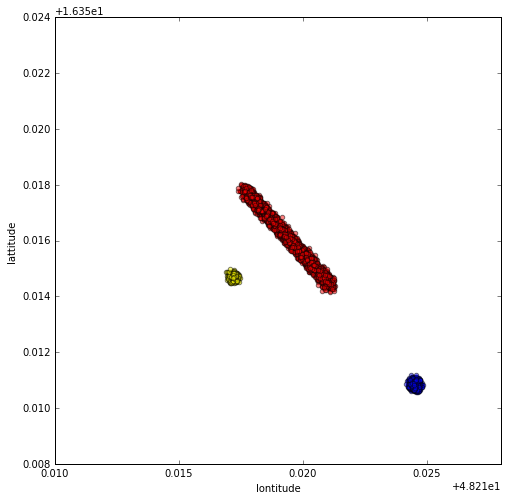

,cluster,data percentage
0,red,0.7166610681894525
1,blue,0.2247228753778972
2,yellow,0.05861605643265032


In [8]:
# plot the results
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1,1,1)  
# different colors for different clusters
colors = ['red','blue','yellow']
for l, c in zip(np.arange(clstr.n_clusters), colors):
    ax.scatter(X[clstr.labels_ == l]['lat'],X[clstr.labels_ == l]['lon'], c=c, alpha=.5)

plt.ylabel("lattitude")
plt.xlabel("lontitude")

plt.show()
# compute the class distribution
class_dist = np.column_stack( [colors, pnd.crosstab(clstr.labels_, 1)/len(X)] )
pnd.DataFrame(class_dist,columns=['cluster','data percentage'])

**We have 3 clusters, the most important are 'red' and 'blue' (~95% of data).**

This shape probably corresponds to the ends of the street?

### Availability over time - historical data

#### Parking events as a stream of availability changes

In [9]:
# book/release events increase or decrease the number of occupied places; this is a stream of +-1 over time!

# ! in the first attempt, we ignore the location (clearly the users may prefer some locations)

pnd.options.mode.chained_assignment = None # disables general warnings about populating data

# prepare the data, convert data types

def preprocess(dt):
    tmp = dt[['ts','type']]
    # in events decrease the availability, out events increase
    tmp['type'] = tmp['type'].apply(lambda t: -1 if t=='IN' else +1)
    tmp['ts'] = pnd.to_datetime(dt['ts'])
    return tmp

def get_time_series(dt):
    # sort increments by time
    dt = dt.sort_values('ts')
    dt  =dt.reset_index(drop=True)
    # compute the series of increments. note: we don't know the total availability in the beginning (set to 0 for know)
    available = 0
    for i in range(len(dt)):
        available = available + dt.loc[i,'type']
        dt.loc[i,'available'] = available 
    tmp = pnd.Series(dt['available'])
    tmp.index = dt['ts']
    return tmp
  
X = preprocess(data)    
X_sort = get_time_series(X)

#### Estimating the initial availability

We don't know the initital availability, but can estimate it assuming the worst case.

In [10]:
# estimate the initial availability

# we shift our series so that the minimum is at 0

av_start = -X_sort.min()

X_sort = X_sort + av_start

print('Inititial availability = %s'%av_start)

Inititial availability = 142.0


*Setting the global miminum of the series to zero is a conservative estimate!* 

Note: with more datails about the initial availability we can get better results.

#### Ploting availability changes

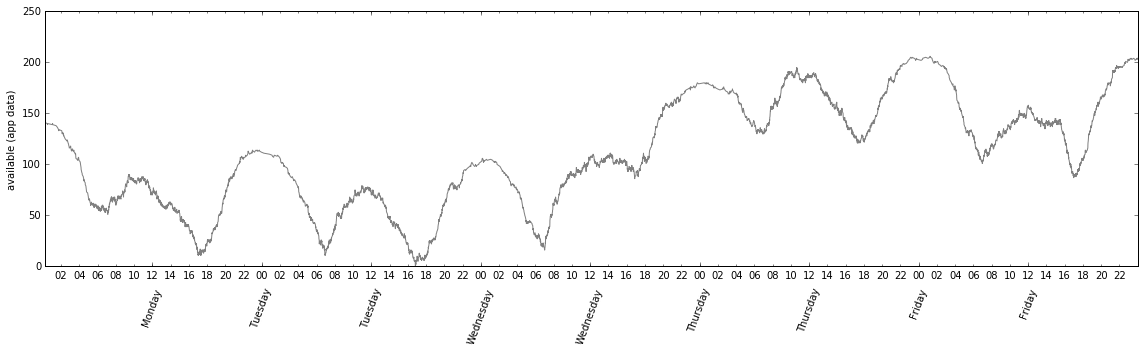

In [11]:
def plot_series(dt,color='gray'):
    # plots the time series of the availability
    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(1,1,1)  
    ax.plot(dt,color=color)

    ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))   #to get a tick every 60 minutes
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H')) 
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=12))   #to get a tick every 24 hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%A')) 
    ax.xaxis.set_tick_params(which='major', pad=20)

    ax.set_ylabel('available (app data)')
    plt.xticks(rotation=70)
    plt.title = 'availability of parking slots based on app data'

    plt.tight_layout()

    plt.show()
    
plot_series(X_sort)

This plot can be used to (roughly!) schedule arrivals to work (assuming - reasonably - a weekly cycle). 

*Note:* the local minima in rush hours (8am-4pm), maxima at midnights and noons, the increasing trend towards Friday!

** Issues: the data collected by mobile app and limited to one historical period! **

We need to address *partial sampling* (the data being a 40% sample) and some *noise* (this specific week being a sample) respectively.

### Location preferences - historical data
Users may prefer specific locations. We illustrate this by computing availability in the three main clusters. This may be applied to any other clustering!

/home/mskorski/.local/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:418: UserWarning: the number of connected components of the connectivity matrix is 3 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_components = _fix_connectivity(X, connectivity)


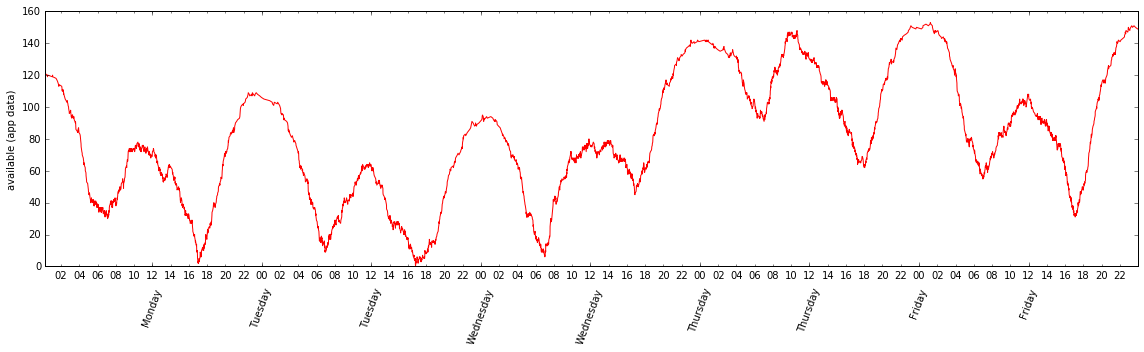

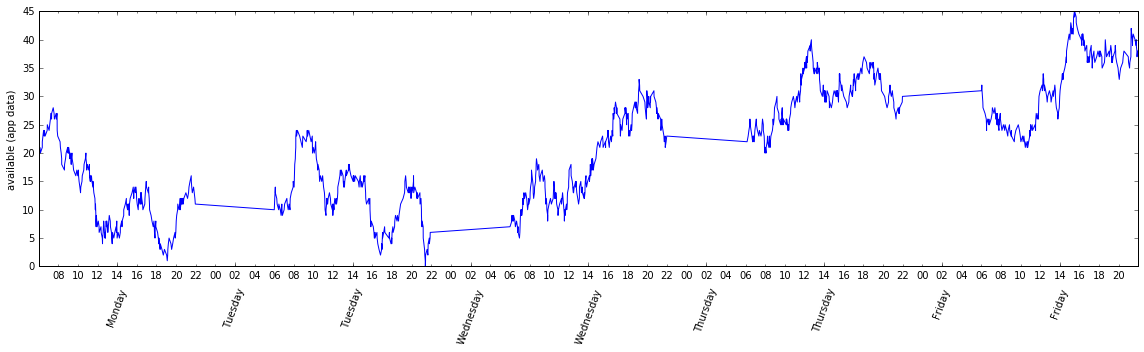

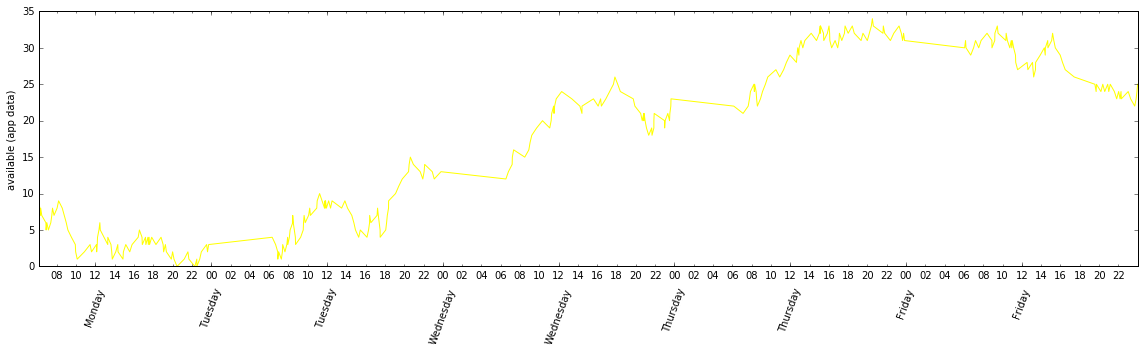

In [12]:
# cluster based on location 
X_loc = data[['lat','lon'] ]
clstr.fit(X_loc)

for l, c in zip(np.arange(clstr.n_clusters), colors):
    dt = data[clstr.labels_ == l]
    dt = preprocess(dt)
    dt_sort = get_time_series(dt)
    dt_sort = dt_sort - dt_sort.min()
    plot_series(dt_sort,color=c)
    

These plots can be used to (roughly!) schedule arrivals with location preferences (the availability changes differently at different locations). 

*Note:* again we need to address errors due to sampling to give more reliable estimates.

### Availability over time - probabilistic modelling

We will build a mathematical model to account sampling issues mentioned above.

#### Binning in equal time units

In the first step we discretize the time series into minute bins (as the parking events are *unevenly spaced* over time)

In [13]:
import datetime, math

# discretizes the given time series over time, up to a given number of seconds
    
# for every time t = i*60, we need to compute: series[t0] where t0 = max{t: t < (i+1)*60 }

def discretize(dt, interval_seconds=60):
    # note: the code is somewhat non-trivial but guarantees one pass over the data (efficiency!)
    # dt is assumed to be a timeseries
    # compute the total number of seconds
    dt1 = pnd.DataFrame(dt)
    name = dt.name
    dt1['total_seconds'] = [ datetime.timedelta.total_seconds( dt.index[t]-dt.index[0] ) for t in range(len(dt))] 
    # compute the length of the binned series
    l = math.floor(dt1['total_seconds'].max() / interval_seconds)
    dt2 = pnd.Series( np.arange(l) )
    dt2_index_list = []
    t0 = 0
    t1 = 0
    j = 0
    for i in range(l):
        # t1 is the first and t0 is the the second smallest value in 'total_seconds' >= (i+1)*60
        # thus, t0 is the biggest t such that t < (i+1)*60 
        av = 0
        while (t1 < (i+1)*60 ):
            j = j+1
            t0 = t1
            t1 = dt1['total_seconds'][j]
        dt2[i] = dt1[name][j]
        dt2_index_list.append(dt.index[j])
    dt2.index = dt2_index_list
    return dt2
        
X_sort_round = discretize(X_sort)

#### Trend and seazonality inspection

We can see that the series exhibits both trendiness and seazonality. We ilustrate them with the help of linear regression.

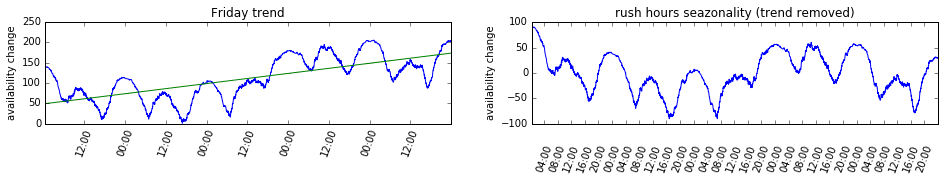

In [14]:
from sklearn import linear_model

clf = linear_model.LinearRegression()

x_plot = np.arange(len(X_sort_round)).reshape(-1,1)

clf.fit(x_plot, X_sort_round)

fig = plt.figure(figsize=(16, 4))

ax = fig.add_subplot(2,2,1)  
ax.plot(X_sort_round)
ax.plot(X_sort_round.index,clf.predict(x_plot))
ax.set_title(label = 'Friday trend' )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
ax.set_ylabel('availability change')
plt.xticks(rotation=70)

ax = fig.add_subplot(2,2,2)  
ax.plot(X_sort_round.index,X_sort_round-clf.predict(x_plot))
ax.set_title(label = 'rush hours seazonality (trend removed)' )
ax.xaxis.set_major_locator(mdates.HourLocator(interval=4))   #to get a tick every 24 hours
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
ax.xaxis.set_tick_params(which='major', pad=20)
ax.set_ylabel('availability change')
plt.xticks(rotation=70)

plt.show()

Oscilation doesn't look that trivial - there is a little trend down towards Wednesday and then up towards Friday. Therefore, we will use more advanced modelling techniques. Gausian processes are very popular in regression and capable to capture trends, sezonality and noise variations.

#### Sampling training points

We need to sample points which will be used to 'anchor' the stochastic process. To get a reasonable model that doesn't overfit we choose only 50 points.

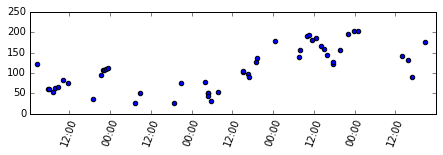

In [15]:
# sampling training points

n_train_samples = 50

np.random.seed(11)
X_train=  np.random.randint(0,len(X_sort_round),n_train_samples)
X_train = np.sort(X_train)
X_train = X_train.reshape(-1,1)
y_train = X_sort_round[X_train]

# plot sampled points
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(2,2,1)  
ax.scatter(X_sort_round.index[X_train],y_train)
ax.set_xlim(min(X_sort_round.index),max(X_sort_round.index))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M')) 
plt.xticks(rotation=70)
plt.show()

#### Gaussian kernel engineering

The shape of a (normalized to zero mean) Gaussian process depends on the *kernel* (covariance), which describes correlations at different times. The kernel should be always taylored to the application at hand, in a way that incoporates assumptions we can made on the data (such as the existence of trends, seazonal behaviors). We use different components to model different behaviors:

a) **weekly trend** modeled by the *exponential squared kernel* (a popular choice to model longer-term dynamics). 
The length scale should be about one day or more to avoid daily flucutations.

<!--The mathematical formula is $K_1(t,t') = \sigma_1^2 \exp\left( -\frac{(t-t')^2}{2\ell_1^2}\right)$-->

b) **daily fluctuations** modeled by the *exponential sine-squared kenrel* (a popular choice to model periodic dynamics). The frequency should be aboout few hours to capture *rush hours seazonality*. The length scale should be much less than one day but bigger than one hour.

<!-- The mathematical formula is $K_2(t,t') = \sigma_2^2 \exp\left( -\frac{\sin^2(t-t')\nu\pi}{2\ell_2^2}\right)$-->

c) **noise** modeled by the *white kernel* (the standard choice) to smooth short-scale deviations (such as measurment errors, delays)

<!-- The mathematical formula is $K_3(t,t') = \sigma_3^2\delta(t,t')$ -->

The final kernel is a weighted mixture of the above three. The parameters are automatically optimized when fitting to the training data, within provided restrictions (however, the optimization is non-convex and may not converge - we account this by passing the option n_restart_optimizer).

**Note on modelling assumptions (!):** without narrowing parameter ranges, the built-in optimization is likely to output unaccurate results; for example the periodic component without lower bounds on the scale length tends to learn variability within intervals less than hour. The alternative to the *modelling assumptions* then is to disable the optimizer and do a grid search manually.

**Note on normalizing:** We normalize the series, by subtracting its mean (this can be also done automatically by enabling a fitting option). This choice is for simplicity and justified by the fact that the average change in availability over the full week is expected to be zero; while we obtain results that look reasonable, there may be better ways to normalize the series (particularly because the average availability change over time).

In [16]:
mean = y_train.mean()

k1 = kernels.ConstantKernel(1, (1e-2,1e1))\
    * kernels.RBF(1e3,length_scale_bounds=(1e3,1e5)) # weekly trend
k2 = kernels.ConstantKernel(1e1, (1e-2,1e4))\
    * kernels.ExpSineSquared(length_scale_bounds=(3e2,1e3),periodicity=700, periodicity_bounds = (6e2,10e2)) # daily variations
k3 = kernels.WhiteKernel(noise_level_bounds=(1e-4,4e-2)) # local noise

kernel = k1+k2+k3

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=11)
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train,y_train-mean)

print('Training points = %s\nOptimized kernel = %s.\nLog-marginal-likelihood = %s\nFitting score = %s'\
      %(X_train.shape[0],gp.kernel_,gp.log_marginal_likelihood_value_,gp.score(X_train,y_train-mean)))

Training points = 50
Optimized kernel = 3.16**2 * RBF(length_scale=1e+03) + 100**2 * ExpSineSquared(length_scale=300, periodicity=716) + WhiteKernel(noise_level=0.04).
Log-marginal-likelihood = -76669.2388336
Fitting score = 0.96549791096


The numbers tell us that most of the variability is explained by the seazonal component, the next important being
the trend component followed by a small amount of white noise. The length scale of the weekly trend is about one day, the frequency of the periodic component is about 12 hours. The model fits well the training data.

Let's illustrate the accuracy on figures. We skeetch seperately the approximations of trend and the trend with seazonability.

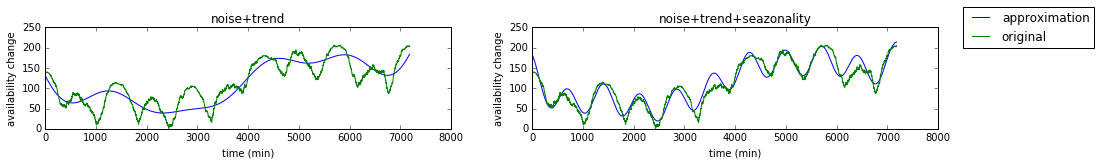

In [17]:
# plot the predictions

x_plot = np.arange(len(X_sort_round)).reshape(-1,1)

fig = plt.figure(figsize=(16, 4))

# trend+noise'
ax = fig.add_subplot(2,2,1)  
kernel = k1+k3
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=11)
gp.fit(X_train,y_train-mean)
y_plot,y_std = gp.predict(x_plot,return_std=True)
ax.plot(x_plot,y_plot+mean)
ax.plot(x_plot,X_sort_round)
ax.set_xlabel('time (min)')
ax.set_ylabel('availability change')
ax.set_title('noise+trend')

# trend+seazonality+noise'
ax = fig.add_subplot(2,2,2)  
kernel = k1+k2+k3
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=11)
gp.fit(X_train,y_train-mean)
# remember also confidence intervals
y_plot,y_std = gp.predict(x_plot,return_std=True)
ax.plot(x_plot,y_plot+mean)
ax.plot(x_plot,X_sort_round)
ax.set_title('noise+trend+seazonality')
ax.set_ylabel('availability change')
ax.set_xlabel('time (min)')

plt.legend(['approximation','original'],bbox_to_anchor=(1.4,1), loc="right")

plt.show()

#### Predictions and errors (estimates for app users data)

Having built the model we can address prediction errors by confidence intervals. We can also illustrate predictions about the nearby future:

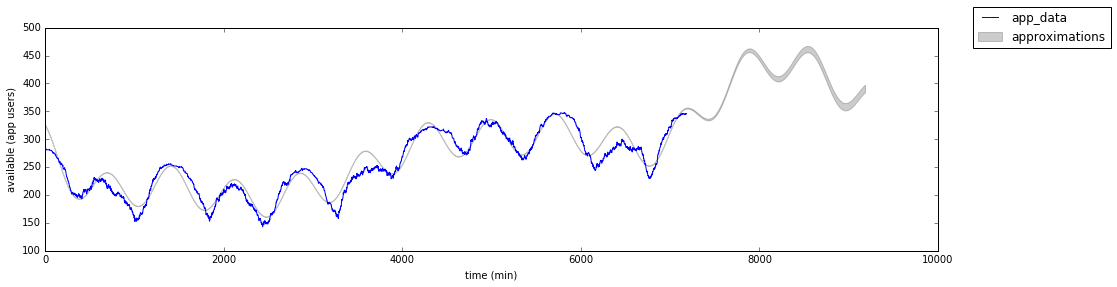

In [18]:
def plot_predictions(gp, y_shift,legend_labels=['app_data','approximations']):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(1,1,1)  
    # original data
    x_plot = np.arange(len(X_sort_round))
    ax.plot(x_plot,X_sort_round - mean + y_shift)   
    # approximations and confidence intervals
    x_plot = np.arange(len(X_sort_round)+2000).reshape(-1,1)
    y_plot,y_std = gp.predict(x_plot,return_std=True)

    y_plot = y_plot.ravel()+y_shift
    x_plot = x_plot.ravel()
    # standard 2*std 95% confidence intervals, in gray
    ax.fill_between(x_plot,y_plot-2*y_std, y_plot+2*y_std, color='black',alpha=0.2)

    ax.legend(legend_labels,bbox_to_anchor=(1.2,1), loc="right")
    ax.set_xlabel('time (min)')
    ax.set_ylabel('available (app users)')

    plt.show()
    
plot_predictions(gp, av_start+mean)

The model fits quite well the data (despite a small number of training points!) and behaves as expected in short-term future (note it learned the *three waves of availability changes*: Mo-Wed,Th-Fri and the highest expected at Sa-So).

*We conclude that our gaussian process doesn't overfit and is a good starting point for more advanced modelling.*

However, more work with the kernel and more data is needed to build an accurate model for weekly predictions.


### Application: best arrival times at work?

Assume that an employee needs to be at work before 10AM. How to schedule the arrival time to have a change for a free parking spot? 

*Note:* we need to take into account the availability for the entire populations (also drivers not using the app); we also use predictions instead of the historical data.

In [19]:
# times of arrivals in minutes
t_ideal_arrivals = []
for i in range(5): t_ideal_arrivals.append(60*10+24*60*i)
t_ideal_arrivals = np.array(t_ideal_arrivals).reshape(-1,1)

days = ['Mon','Tue','Wed','Thu','Fri']

# we assume that the change in the availability between time 0 and time t is proportional to the population size 

scaling_factor = 1/0.4

# justification: the occupation change depends on the place and the day of the week, 
# assuming the app users are chosen at random, we observe a 0.4 fraction of the flow

# use the predictions rather than the historical data (because of the assumptions above, shifts doesn't matter)

y_pred = y_plot

av_start+( y_pred[t_ideal_arrivals]-y_pred[0] - 2*y_std )*scaling_factor

pnd.DataFrame(
pnd.Series( index = np.array(days), data=gp.predict(t_ideal_arrivals).ravel(),name='estimated availability at 10am') )

,estimated availability at 10am
Mon,-20.583816
Tue,-30.971333
Wed,12.901795
Thu,77.390206
Fri,67.908130


We conclude that in period Wed-Fri should be possible to get a free spot when arriving around 10am. 

This is not guaranteed for Mon-Tue, but the trend is increasing since 6am towards 10am - to maximize the chances it is better to arrive as late as possible before 10 am.

## Conclusion

We showed how to estimate parking slots availability with Gaussian processes, and account data trendiness and seazonality by kernel ingeneering. The model trained on a small number of samples fits well the data and matches reasonable expectations, e.g. predicts highest availability during the weekend.

This simple model may be a good starting point to a more quantitative estimates, given more training data is given.

There also other approaches that may be successfully applied, for example ideas from *queeing theory* (entering parking slot as arrival events, leaving as departure times, modeled probabilistically).